# Convolution of 1D signals
We start with a brute force convolution implementation:

In [1]:
import numpy as np
def convolution_brute_force(signal, kernel):
    l, r = len(kernel)//2, len(kernel)-len(kernel)//2
    padded_signal = np.hstack([signal[-r:], signal, signal[:r]]) #periodic padding
    convolution = np.zeros(len(padded_signal))
    flipped_kernel = np.flip(kernel)
    for i in range(l, len(padded_signal)-l):
        convolution[i] = np.sum(flipped_kernel * padded_signal[i-l: i+r])
    return convolution[r:-r]

An alternative is to use "fast convolution" by the help of Fourier Transform as explained in the presentation:

In [2]:
from numpy.fft import fft, ifft
def convolution_fft(signal, kernel):
    f_kernel = np.zeros(len(signal))
    f_kernel[:len(kernel)] = kernel
    f_kernel = np.roll( f_kernel, - (len(kernel)//2) ) #centers the kernel around the 0th - entry
    convolution = ( ifft( fft( signal) * fft( f_kernel) ) ).real
    return convolution

Just some test function for convolution:

In [3]:
import matplotlib.pyplot as plt
def test_convolution(signal, kernel):
    # do convolution by two different ways
    conv_bf = convolution_brute_force(signal, kernel)
    conv_fft = convolution_fft(signal, kernel)
    # plot the result
    fig, ax = plt.subplots()
    ax.plot(signal, label='signal')
    ax.plot(conv_bf, label='brute force convolution')
    ax.plot(conv_fft, label='fft convolution', ls='--', marker='o', mec='k', color='black')
    ax.grid( ls=':', color='gray')
    ax.legend()
    ax.set_title('convolution test')
    plt.show()

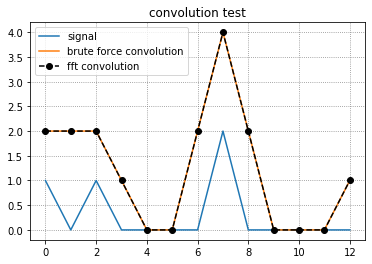

In [4]:
signal = np.array( [ 1,0,1,0,0,0,0,2,0,0,0,0,0 ] )
kernel = np.array( [ 1,2,1] )
test_convolution(signal, kernel)

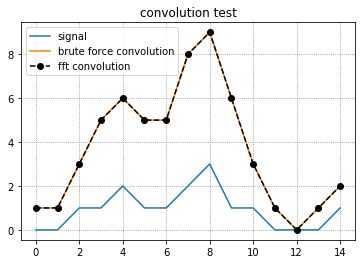

In [5]:
signal = np.array([0,0,1,1,2,1,1,2,3,1,1,0,0,0,1])
kernel = np.array([0,1,2,1,0])
test_convolution(signal, kernel)

Just some performance measurements:

In [6]:
import timeit
import math
import statistics
import matplotlib.pyplot as plt
from IPython.display import HTML, display
%matplotlib notebook

def test(func, n=2**10, samples=100):
    data = np.random.randint(-10, 10, size=n)
    #kernel = np.random.rand(n//4)
    kernel = np.ones(3)
    f = lambda: func(data, kernel)
    times = timeit.Timer(f).repeat(samples, 1)
    mean = statistics.mean(times)
    return mean

def O_logn(n):
    return np.log2(n)
def O_n(n):
    return n
def O_nlogn(n):
    return n*np.log2(n)
def O_n2(n):
    return n**2
def O_n3(n):
    return n**3
    return n**2
def O_n4(n):
    return n**4
def testCycle(funcs, Os=[O_n, O_nlogn, O_n2], start=2**3, end=2**16, samples=10, verbose=False):
    n = start
    iterations = np.array([])
    times = [[] for f in funcs]
    #plt.xscale("log", basex=2)
    #plt.yscale("log")
    fig, ax = plt.subplots(1, 1)
    fig2, ax2 = plt.subplots(1, len(funcs))
    plt.ion()
    fig.show()
    fig.canvas.draw()
    while n <= end:
        row = []
        iterations = np.append(iterations, n)
        if verbose:
            ax.clear()
            ax.set_xscale('log', basex=2)
            ax.set_yscale('log')
        for i, func in enumerate(funcs):
            if verbose:
                ax2[i].clear()
                ax2[i].set_xscale('log', basex=2)
                ax2[i].set_yscale('log')
            time = test(func, n, samples)
            if time < 1e-3:
                time = test(func, n, int(samples/math.sqrt(time)))
            times[i].append(time)
            row.append(str(time))
            if verbose:
                ax.plot(iterations, times[i])
                ax2[i].plot(iterations, times[i]/O_logn(iterations), label=O_logn.__name__)
                ax2[i].plot(iterations, times[i]/O_n(iterations), label=O_n.__name__)
                ax2[i].plot(iterations, times[i]/O_nlogn(iterations), label=O_nlogn.__name__)
                ax2[i].legend()
        if verbose:
            fig.canvas.draw()
            fig2.canvas.draw()
        print(n, '|', ' | '.join(row))
        n *= 2
    #for i, func in enumerate(funcs):
    #    plt.plot(iterations, times[i])
    #plt.xscale("log", basex=2)
    #plt.yscale("log")
    return times

In [7]:
test(convolution_brute_force)

0.005405694000000079

In [8]:
test(convolution_fft)

7.99780000000716e-05

You can see, that `convolution_fft` is in fact faster than `convolution_brute_force`.

The difference would be even more bigger with a longer kernel.

<IPython.core.display.Javascript object>


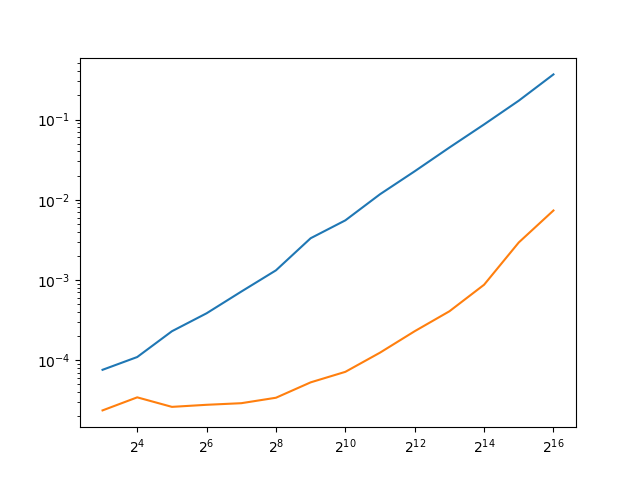

<IPython.core.display.Javascript object>


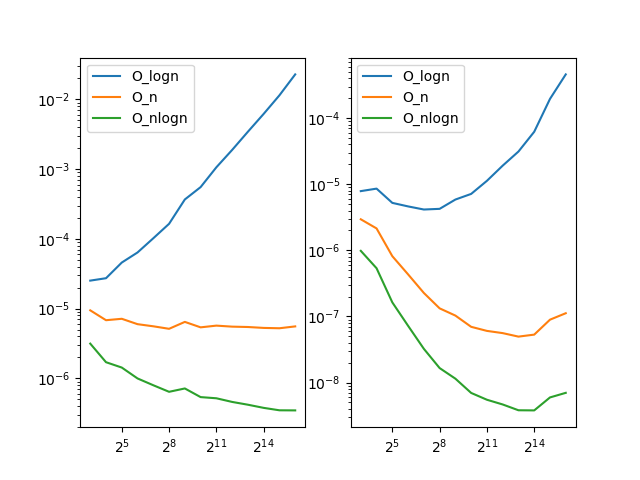

8 | 7.571681109182415e-05 | 2.361157333332547e-05
16 | 0.00010931393617020473 | 3.4345420258616024e-05
32 | 0.0002291092145015685 | 2.6129302325626864e-05
64 | 0.00038369389002039327 | 2.7731148459299876e-05
128 | 0.000715286416185051 | 2.9033652121966993e-05
256 | 0.0013170200000004683 | 3.396510883478441e-05
512 | 0.0033093900000000787 | 5.2822135619684316e-05
1024 | 0.005528150000000664 | 7.142988115452894e-05
2048 | 0.011701879999999675 | 0.00012394480874318827
4096 | 0.022630049999999714 | 0.00022942396946564129
8192 | 0.04472456000000058 | 0.00040619416666668834
16384 | 0.08680139999999988 | 0.000870781901840384
32768 | 0.17167509000000009 | 0.0029310000000009493
65536 | 0.36501428000000014 | 0.007338939999999639


In [9]:
testCycle([convolution_brute_force, convolution_fft], end=2**16, verbose=True);